In [47]:
import numpy as np
import pandas as pd

In [48]:
path = r"D:\download\gps_example.csv"
def add_random_error(lat, n, pos_error, neg_error):
    for i in range(n):
        pos = np.random.randint(len(lat))
        if np.random.rand() < 0.5:
            lat[pos] = lat[pos] + pos_error
        elif lat[pos] > neg_error:
            lat[pos] = lat[pos] - neg_error
        else:
            lat[pos] = 0
    return(lat)
gps_example = pd.read_csv(path, sep = ",")
lat = gps_example.iloc[:,1].copy()

In [49]:
# 测试模型效果，加上随机误差
lat = add_random_error(lat, 10, np.random.rand()/500, np.random.rand()/500)

In [50]:
def particle_filter_lat(lat):
    lat = lat * 100000
    x_N = 30 # 系统过程噪声的协方差，由于是一维的,这里就是方差，适用于速度滤波
    x_R = 20 # 测量的协方差，适用于速度滤波
    T = len(lat)
    N = 100 # 粒子数，越大效果越好，计算量也越大
    V = 20   #初始分布的方差
    x = lat[0] # 初始值
    x_P = [] #粒子群
    # 用一个高斯分布随机的产生初始的粒子
    x_P = [(x + np.sqrt(V) * np.random.randn()) for i in range(N)]
    z_out = [x + np.sqrt(x_R) * np.random.randn()]  #实际测量值
    x_out = [x]  # 测量值
    x_est = x # 单步的particle filters估计值    
    x_est_out = [x_est/100000] # particle filters估计值list
    for t in range(1, T):
        P_w = []
        x_P_update = []
        z_update = []
        # 状态值含误差
        x = lat[t] # 转移方程，直接用下一步的测量值作为转移方程+误差得到的值
        # 观察值含误差
        z = x + np.sqrt(x_R)*np.random.randn()
        for i in range(N):
            # 从先验p(x(k)|x(k-1))中采样
            x_P_update.append(x_P[i] + np.sqrt(x_N)*np.random.randn())
            # 计算采样粒子的值，为后面根据似然去计算权重做铺垫    
            z_update.append(x_P_update[i])
            # 对每个粒子计算其权重，这里假设量测噪声是高斯分布。所以 w = p(y|x)对应下面的计算公式    
            P_w.append((1/np.sqrt(2*np.pi*x_R)) * np.exp(-(z - z_update[i])**2/(2*x_R)))
        # 归一化.
        if np.sum(P_w) == 0:
            x_est_out.append(x_est)
        else:
            P_w = P_w/np.sum(P_w)
            # Resampling这里没有用博客里之前说的histc函数，不过目的和效果是一样的，重采样
            P_w_sum = np.cumsum(P_w)
            for i in range(N):
                index0 = np.where(np.random.random() < P_w_sum)
                x_P[i] = x_P_update[index0[0][0]] # 粒子权重大的将多得到后代  # find( ,1) 返回第一个 符合前面条件的数的 下标
            # 状态估计，重采样以后，每个粒子的权重都变成了1/N
            x_est = np.mean(x_P)
            if x_est < 0:
                x_est = 0 
            # Save data in arrays for later plotting    
            if np.abs(x-x_est) <= 30:
                x_est = 0.8*x + 0.2*x_est
            x_est=x_est/100000
            x_est_out.append(x_est)
    return(x_est_out)

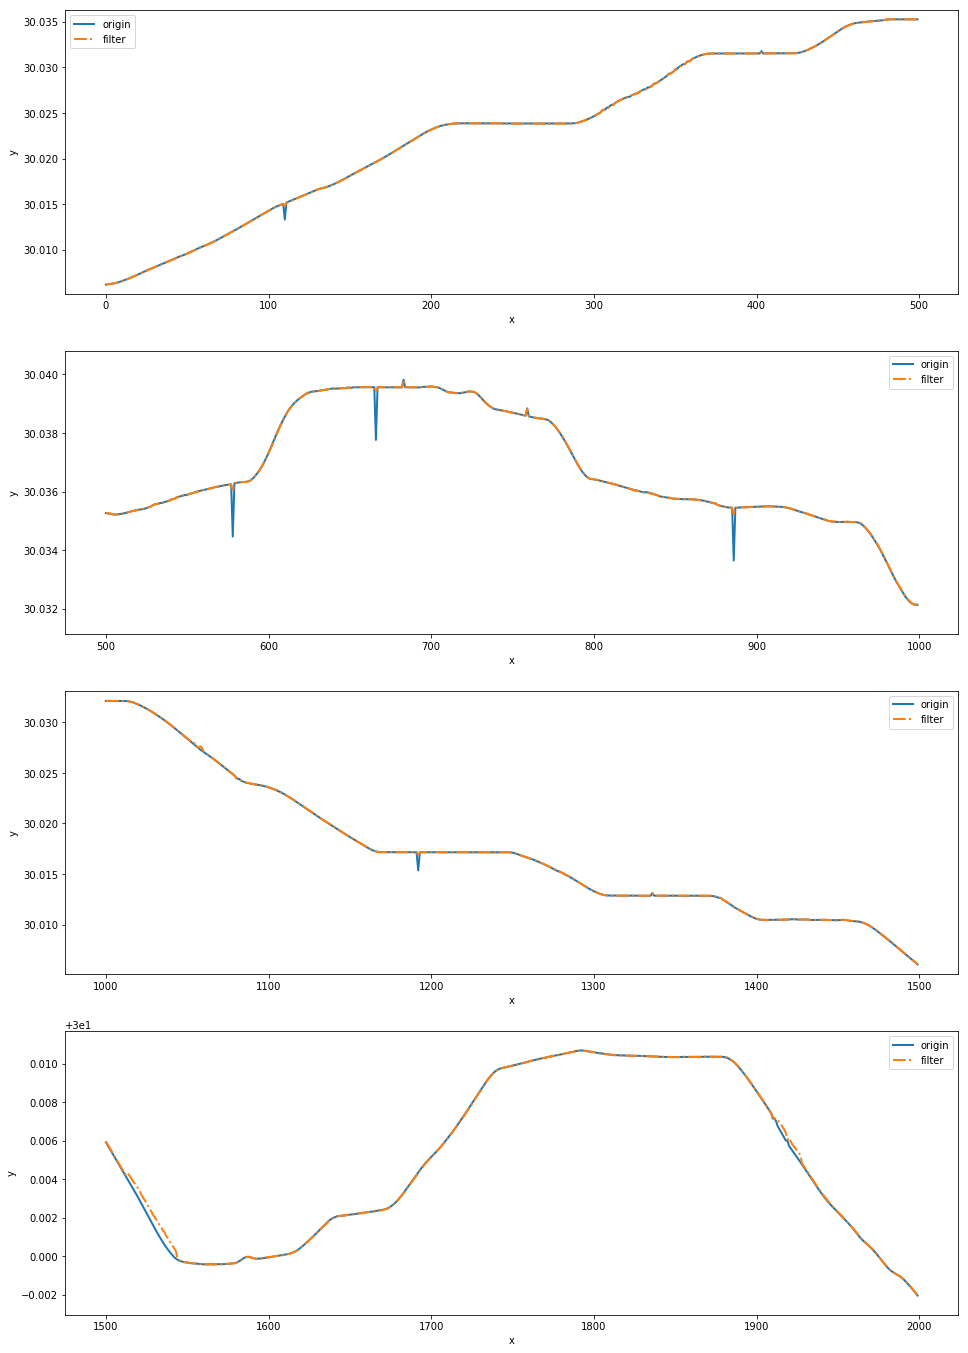

In [51]:
import matplotlib.pyplot as plt
t = [i for i in range(len(lat))]
x_est_out = particle_filter_lat(lat)
plt.figure(figsize=(16,24), facecolor = "white")
for i in range(4):
    plt.subplot(411+i)
    start=i*500
    plt.plot(t[start:start+500], lat[start:start+500], linestyle="-", linewidth=2, label='origin')
    plt.plot(t[start:start+500], x_est_out[start:start+500], linestyle="-.", linewidth=2, label='filter')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(min(lat[start:start+500])-0.001, max(lat[start:start+500])+0.001)
    plt.legend()
plt.show()